In [69]:
import numpy as np
import pandas as pd
from scipy.optimize import minimize
from scipy.stats import binom
from scipy.stats import poisson
from scipy.special import logsumexp

## Basal dNdSCV

In [ ]:
# Load df with observed and expected counts
gene_mut = pd.read_csv('data/evaluation/dndscv_gene_muts.csv')
gene_mut['obs_mut'] = gene_mut[['n_mis', 'n_non', 'n_spl']].sum(axis=1) # observed nonsynonymous
gene_mut['exp_mut'] = gene_mut[['exp_mis', 'exp_non', 'exp_spl']].sum(axis=1)    # expected neutral counts

In [ ]:
# Negative log-likelihood of Poisson mixture
def neg_log_likelihood(params, k, lam):
    pi, r_driver = params
    pi = np.clip(pi, 1e-5, 1 - 1e-5)
    r_driver = np.clip(r_driver, 1, 1000)  # must be ≥ 1

    pois_driver = poisson.pmf(k, lam * r_driver)
    pois_passenger = poisson.pmf(k, lam)
    
    mix = pi * pois_driver + (1 - pi) * pois_passenger
    return -np.sum(np.log(np.clip(mix, 1e-12, None)))  # to avoid log(0)

In [ ]:
# Poisson initial guesses: pi, r_driver
initial_params = [0.1, 10]  # pi=0.1, r_driver=10

# Poisson: Constrain pi between 0 and 1, r_driver ≥ 1
bounds = [(1e-5, 1 - 1e-5), (1.0, 1000.0)]  # for pi and r_driver

# Poisson: Minimize
result = minimize(neg_log_likelihood, initial_params, args=(gene_mut['obs_mut'].to_numpy(), gene_mut['exp_mut'].to_numpy()), bounds = bounds, method='L-BFGS-B')

# Poisson: Extract parameters
pi_fit, r_driver_fit = result.x
print(f"Estimated pi: {pi_fit:.3f}")
print(f"Estimated r_driver: {r_driver_fit:.4f}")

Estimated pi: 0.739
Estimated r_driver: 708.5705


In [ ]:
# Poisson: Posterior probability of being a driver
def posterior_driver(obs, exp, pi, r_driver):
    driver_likelihood = poisson.pmf(obs, exp * r_driver)
    passenger_likelihood = poisson.pmf(obs, exp)
    # print(f"Observed: {obs}, Expected: {exp}")
    # print(f"Driver likelihood: {driver_likelihood}, Passenger likelihood: {passenger_likelihood}")
    # print(f"pi: {pi_fit}, r_driver: {r_driver_fit}")
    numerator = np.clip(pi * driver_likelihood, 1e-300, None)
    denominator = np.clip(numerator + (1 - pi) * passenger_likelihood, 1e-300, None)
    posterior = numerator / denominator
    assert np.all((posterior >= 0) & (posterior <= 1))
    return posterior



In [46]:
posteriors = []

for o, e in zip(gene_mut['obs_mut'], gene_mut['exp_mut']):
    posteriors.append(posterior_driver(np.array(o), np.array(e), pi_fit, r_driver_fit))

# print(posteriors)  # now you have posterior driver probabilities per gene

In [ ]:
gene_mut['posterior_driver'] = posteriors
# gene_mut.to_csv('/Users/aleyshachen/BENG_285/proj_2/dndscv_gene_muts_posterior.csv', index=False)

In [ ]:
# Combine with corresponding q-values
q_values = pd.read_csv('data/evaluation/dndscv_gene_level.csv')
gene_mut = pd.merge(gene_mut, q_values[['gene_name', 'qglobal_cv']], on='gene_name', how='left')
gene_mut

gene_name  n_syn  n_mis  n_non  n_spl   exp_syn   exp_mis   exp_non  \
0          A1BG      0      2      0      0  0.000663  0.001411  0.000108   
1          A1CF      0      1      0      0  0.000425  0.001342  0.000137   
2           A2M      0      3      1      0  0.001202  0.003300  0.000320   
3         A2ML1      0      6      0      0  0.001210  0.003317  0.000304   
4       A3GALT2      0      0      1      0  0.000487  0.001048  0.000068   
...         ...    ...    ...    ...    ...       ...       ...       ...   
20086    ZYG11A      0      0      0      0  0.000534  0.001610  0.000140   
20087    ZYG11B      0      1      0      0  0.000495  0.001586  0.000140   
20088       ZYX      0      0      0      0  0.000653  0.001573  0.000118   
20089     ZZEF1      0      2      0      0  0.002572  0.007095  0.000653   
20090      ZZZ3      0      1      0      0  0.000466  0.001951  0.000229   

        exp_spl  exp_syn_cv  obs_mut   exp_mut  posterior_driver  qglobal_cv  
0      0.000045    0.000663        2  0.001564          0.999998    0.031838  
1      0.000071    0.000425        1  0.001550          0.998513    0.024837  
2      0.000229    0.001202        4  0.003849          1.000000    0.028649  
3      0.000223    0.001210        6  0.003844          1.000000    0.021314  
4      0.000028    0.000487        1  0.001144          0.998884    0.026938  
...         ...         ...      ...       ...               ...         ...  
20086  0.000082    0.000534        0  0.001831          0.437110    1.000000  
20087  0.000086    0.000495        1  0.001812          0.998210    0.079036  
20088  0.000056    0.000653        0  0.001748          0.451693    1.000000  
20089  0.000343    0.002572        2  0.008091          0.999785    0.068948  
20090  0.000059    0.000466        1  0.002240          0.997579    0.089141  

[20091 rows x 14 columns]

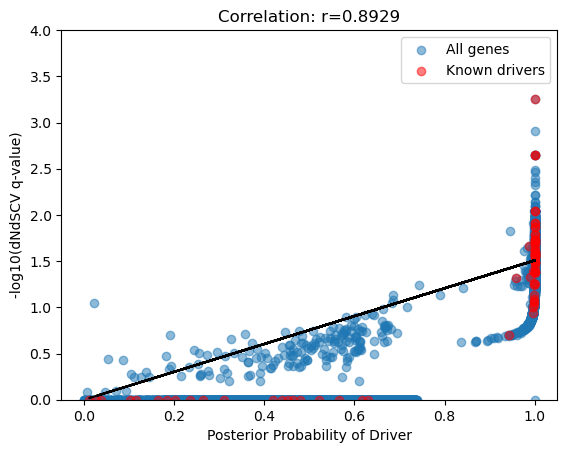

In [ ]:
# Posterior vs. q-value
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
plt.scatter(gene_mut['posterior_driver'], -np.log10(gene_mut['qglobal_cv']), alpha=0.5)

# Label known cancer drivers
known_drivers_df = pd.read_csv('data/benchmark/IntOGen-DriverGenes_LUAD.tsv', sep='\t')
known_drivers = known_drivers_df['Symbol'].tolist()
# known_drivers = [x.lower() for x in known_drivers]
X = gene_mut[gene_mut['gene_name'].isin(known_drivers)]['posterior_driver'].to_numpy().reshape(-1, 1)
y = -np.log10(gene_mut[gene_mut['gene_name'].isin(known_drivers)]['qglobal_cv'])

plt.scatter(gene_mut[gene_mut['gene_name'].isin(known_drivers)]['posterior_driver'], -np.log10(gene_mut[gene_mut['gene_name'].isin(known_drivers)]['qglobal_cv']), color='red', alpha=0.5)
plt.xlabel('Posterior Probability of Driver')
plt.ylabel('-log10(dNdSCV q-value)')
plt.legend(['All genes', 'Known drivers'])

# Add correlation line
# from scipy.stats import linregress
# Fit with intercept = 0
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Predict line
y_pred = model.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum(y ** 2)
r_squared = 1 - (ss_res / ss_tot)

plt.title(f"Correlation: r={r_squared:.4f}")
plt.plot(gene_mut[gene_mut['gene_name'].isin(known_drivers)]['posterior_driver'], y_pred, color='black', linestyle='dashed')
# plt.plot(x, y, color='red', linestyle='--')
plt.ylim(0, 4)
# plt.title(f'Correlation: r={r_value:.2f}, p={p_value:.2e}')
plt.show()



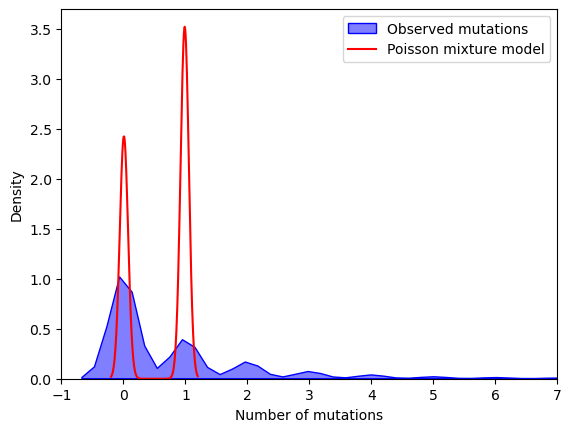

In [182]:
# Plot driver poisson vs. passenger poisson vs. distribution of observed mutations
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the distributions
sns.kdeplot(gene_mut['obs_mut'], label='Observed mutations', color='blue', fill=True, alpha=0.5)
sns.kdeplot(poisson.pmf(gene_mut['obs_mut'], gene_mut['exp_mut'] * r_driver_fit), label='Poisson mixture model', color='red')
# sns.kdeplot(poisson.pmf(gene_mut['obs_mut'], gene_mut['exp_mut']), label='Passenger mutations Poisson', color='green')
plt.xlabel('Number of mutations')
plt.ylabel('Density')
plt.xlim(-1, 7)
plt.legend()

(0.0, 20.0)

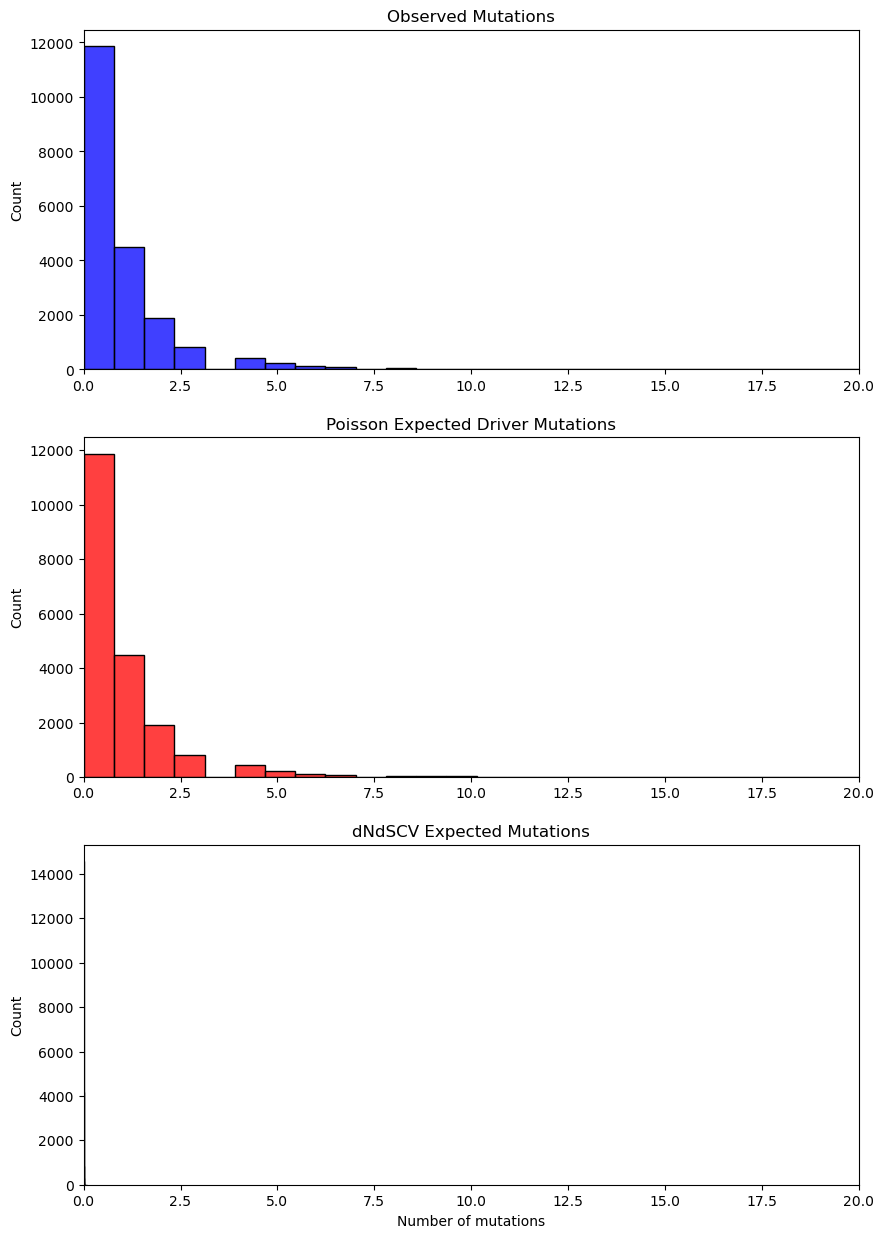

In [128]:
# Plot observed vs. expected vs. Poisson posterior expected mutations
plt.figure(figsize=(10, 15))

# Plot 1: Observed mutations
plt.subplot(3, 1, 1)
sns.histplot(gene_mut['obs_mut'], label='Observed mutations', color='blue', bins=50)
plt.xlabel('')
plt.title('Observed Mutations')
plt.xlim(0,20)

# Plot 2: Poisson expected driver mutations
plt.subplot(3, 1, 2)
sns.histplot(gene_mut['posterior_driver'] * gene_mut['obs_mut'], label='Poisson expected driver mutations', color='red', bins=50)
plt.xlabel('')
plt.title('Poisson Expected Driver Mutations')
plt.xlim(0,20)

# Plot 3: dNdSCV expected mutations
plt.subplot(3, 1, 3)
sns.histplot(gene_mut['exp_mut'], label='dNdSCV expected mutations', color='green', bins=50)
plt.title('dNdSCV Expected Mutations')
plt.xlabel('Number of mutations')
plt.xlim(0,20)

## Custom dNdS 

In [ ]:
# Load df with observed and expected counts
custom_mut = pd.read_csv('results/simplified_dNdSpy_results/gene_results.csv')
custom_mut['obs_mut'] = custom_mut[['n_mis', 'n_non', 'n_spl']].sum(axis=1) # observed nonsynonymous
custom_mut['exp_mut'] = custom_mut[['exp_mis', 'exp_non', 'exp_spl']].sum(axis=1)    # expected neutral counts

In [ ]:
# Negative log-likelihood of binomial mixture
def binom_neg_log_likelihood(params, obs, exp):
    pi_driver, logit_p_driver, logit_p_passenger = params
    p_driver = 1 / (1 + np.exp(-logit_p_driver))
    p_passenger = 1 / (1 + np.exp(-logit_p_passenger))
    
    n = np.round(exp).astype(int)
    
    log_likelihood_driver = binom.logpmf(obs, n, p_driver)
    log_likelihood_passenger = binom.logpmf(obs, n, p_passenger)
    
    log_total = logsumexp(
        np.vstack([
            np.log(pi_driver) + log_likelihood_driver,
            np.log(1 - pi_driver) + log_likelihood_passenger
        ]),
        axis=0
    )
    
    return -np.sum(log_total)

In [ ]:
# Binom initial guesses: pi_driver, logit_p_driver, logit_p_passenger
initial_params = [0.1, 0, -5]  # pi=0.1, p_driver=0.5, p_passenger=~0.0067

# Binom: Constrain pi
bounds = [
    (1e-5, 1.0),        # pi_driver
    (np.log(1e-5), np.log(0.05 / (1 - 0.05))),  # logit(p_driver)
    (np.log(1e-6), np.log(0.01 / (1 - 0.01)))   # logit(p_passenger)
]

# Binom: Minimize
result = minimize(binom_neg_log_likelihood, initial_params, args=(custom_mut['obs_mut'].to_numpy(), custom_mut['exp_mut'].to_numpy()), bounds=bounds)

# Binom: Extract parameters
pi_driver, logit_p_driver, logit_p_passenger = result.x
p_driver = 1 / (1 + np.exp(-logit_p_driver))
p_passenger = 1 / (1 + np.exp(-logit_p_passenger))

print(f"Estimated pi_driver: {pi_driver:.3f}")
print(f"Estimated p_driver: {p_driver:.4f}")
print(f"Estimated p_passenger: {p_passenger:.4f}")

Estimated pi_driver: 0.235
Estimated p_driver: 0.0008
Estimated p_passenger: 0.0001


In [195]:
# Binom: Posterior probability of being a driver
def binom_posterior_driver(obs, exp, pi_driver, p_driver, p_passenger):
    print(f"Observed: {obs}, Expected: {exp}")
    n = np.round(exp).astype(int)

    log_driver = np.log(pi_driver) + binom.logpmf(obs, n, p_driver)
    log_passenger = np.log(1 - pi_driver) + binom.logpmf(obs, n, p_passenger)
    print(f"Driver log-likelihood: {log_driver}, Passenger log-likelihood: {log_passenger}")

    log_norm = logsumexp(np.vstack([log_driver, log_passenger]), axis=0)
    log_posterior = log_driver - log_norm
    posterior = np.exp(log_posterior)
    
    return posterior

In [196]:
custom_posteriors = []

for o, e in zip(custom_mut['obs_mut'], custom_mut['exp_mut']):
    custom_posteriors.append(binom_posterior_driver(np.array(o), np.array(e), pi_driver, p_driver, p_passenger))

print(custom_posteriors)  # now you have posterior driver probabilities per gene

Observed: 113, Expected: 3082.2583997228944
Driver log-likelihood: -326.1234787570275, Passenger log-likelihood: -533.3029885122561
Observed: 125, Expected: 22482.84031866979
Driver log-likelihood: -138.1516019956615, Passenger log-likelihood: -354.29448229030515
Observed: 55, Expected: 18288.207828195336
Driver log-likelihood: -36.04803811046722, Passenger log-likelihood: -124.69576156918556
Observed: 45, Expected: 43490.84308971221
Driver log-likelihood: -5.4389969620466925, Passenger log-likelihood: -58.06615096292757
Observed: 42, Expected: 7533.6224454451
Driver log-likelihood: -49.1451421591246, Passenger log-likelihood: -120.99920817021179
Observed: 17, Expected: 95506.79598199061
Driver log-likelihood: -38.90809948015299, Passenger log-likelihood: -3.481258580434355
Observed: 4, Expected: 28374.362313820424
Driver log-likelihood: -15.233607896723578, Passenger log-likelihood: -1.9220453634284282
Observed: 0, Expected: 4522.685140284031
Driver log-likelihood: -5.143805526343816,

In [197]:
custom_posteriors_list = np.concatenate(custom_posteriors).ravel()
custom_mut['posterior_driver'] = custom_posteriors_list
custom_mut.head(10)

gene_name  n_syn  n_mis  n_non  n_spl       exp_syn       exp_mis  \
0      KRAS      0    112      1      0    826.263942   2825.355040   
1      TP53      7     94     25      6   7831.903014  20884.320055   
2     KEAP1      1     46      8      1   6721.643228  16909.652927   
3      EGFR      0     44      1      0  14919.836508  39904.817458   
4     STK11      2     21     14      7   2934.874957   6987.624524   
5     MUC5B     21     15      2      0  32761.377208  90731.136820   
6   CACNA1S     11      4      0      0  10371.807413  26135.625909   
7     OR7G1      5      0      0      0   1543.351576   4228.852096   
8      CHAT      5      0      0      0  10799.190856  27733.400762   
9       EVC      7      1      0      0   6988.400416  17813.295462   

       exp_non  exp_spl  exp_syn_counts  ...  dnds_global   dnds_mis  \
0   256.903360        0           917.0  ...          NaN        NaN   
1  1598.520263        0          6372.0  ...     6.220540   5.035896   
2  1378.554901        0          5452.0  ...    20.214686  18.285153   
3  3586.025632        0         12340.0  ...          NaN        NaN   
4   545.997922        0          2166.0  ...     8.180975   4.410109   
5  4775.659162        0         24683.0  ...     0.277688   0.257916   
6  2238.736405        0          7978.0  ...     0.132922   0.144307   
7   293.833045        0          1315.0  ...     0.000000   0.000000   
8  2189.686179        0          8572.0  ...     0.000000   0.000000   
9  1605.253897        0          5334.0  ...     0.051412   0.056045   

    dnds_non         lr       p_value       q_value  significant  obs_mut  \
0        NaN  53.674279  2.366411e-13  3.672670e-09         True      113   
1  17.498109  38.929922  4.392953e-10  3.408932e-06         True      125   
2  39.006895  27.026600  2.006748e-07  9.988036e-04         True       55   
3        NaN  26.545350  2.574236e-07  9.988036e-04         True       45   
4  37.626745  16.450510  4.993675e-05  1.550037e-01        False       42   
5   0.653340  15.094785  1.022454e-04  2.644747e-01        False       17   
6   0.000000  14.089605  1.743044e-04  3.864577e-01        False        4   
7   0.000000  13.687491  2.158878e-04  4.188222e-01        False        0   
8   0.000000  13.273041  2.692501e-04  4.350072e-01        False        0   
9   0.000000  13.197732  2.802881e-04  4.350072e-01        False        1   

        exp_mut  posterior_driver  
0   3082.258400      1.000000e+00  
1  22482.840319      1.000000e+00  
2  18288.207828      1.000000e+00  
3  43490.843090      1.000000e+00  
4   7533.622445      1.000000e+00  
5  95506.795982      4.114513e-16  
6  28374.362314      1.655241e-06  
7   4522.685140      1.335917e-02  
8  29923.086941      3.301584e-10  
9  19418.549359      2.991936e-06  

[10 rows x 23 columns]

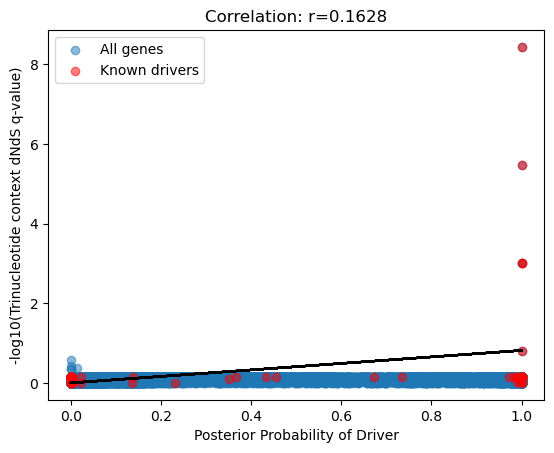

In [198]:
# Posterior vs. q-value
import matplotlib.pyplot as plt
plt.scatter(custom_mut['posterior_driver'], -np.log10(custom_mut['q_value']), alpha=0.5)

# Label known cancer drivers
# known_drivers_df = pd.read_csv('/Users/aleyshachen/BENG_285/proj_2/IntOGen-DriverGenes_LUAD.csv')
# known_drivers = known_drivers_df['Symbol'].tolist()
# known_drivers = [x.lower() for x in known_drivers]
X = custom_mut[custom_mut['gene_name'].isin(known_drivers)]['posterior_driver'].to_numpy().reshape(-1, 1)
y = -np.log10(custom_mut[custom_mut['gene_name'].isin(known_drivers)]['q_value'])

# Add correlation line
# from scipy.stats import linregress
# Fit with intercept = 0
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Predict line
y_pred = model.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum(y ** 2)
r_squared = 1 - (ss_res / ss_tot)
plt.title(f"Correlation: r={r_squared:.4f}")
plt.scatter(custom_mut[custom_mut['gene_name'].isin(known_drivers)]['posterior_driver'], -np.log10(custom_mut[custom_mut['gene_name'].isin(known_drivers)]['q_value']), color='red', alpha=0.5)
plt.plot(custom_mut[custom_mut['gene_name'].isin(known_drivers)]['posterior_driver'], y_pred, color='black', linestyle='dashed')
plt.xlabel('Posterior Probability of Driver')
plt.ylabel('-log10(Trinucleotide context dNdS q-value)')
plt.legend(['All genes', 'Known drivers'])

## Permutation dNdSCV

In [ ]:
# Load df with observed and expected counts
perm_mut = pd.read_csv('data/evaluation/permutation_res_2000.csv')

<Axes: xlabel='n_mutation', ylabel='Count'>

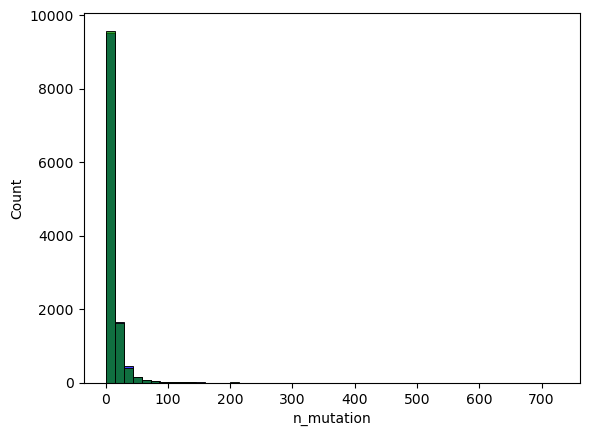

In [211]:
sns.histplot(perm_mut['n_mutation'], label='Observed mutations', color='blue', bins=50)
sns.histplot(perm_mut['n_mutation_est'], label='Expected mutations', color='green', bins=50)

In [212]:
print('Var: ', np.var(perm_mut['n_mutation_est']))
print('Mean: ', np.mean(perm_mut['n_mutation_est']))

Var:  257.2905856564672
Mean:  11.569149417093016


In [213]:
# Binom initial guesses: pi_driver, logit_p_driver, logit_p_passenger
initial_params = [0.1, 0, -5]  # pi=0.1, p_driver=0.5, p_passenger=~0.0067

# Binom: Constrain pi between 0 and 1
# bounds = [(0.001, 0.999), (None, None), (None, None)]
bounds = [
    (1e-5, 0.5),  # pi_driver
    (np.log(1e-6), np.log(0.95 / (1 - 0.95))),  # logit(p_driver)
    (np.log(1e-6), np.log(0.5 / (1 - 0.5)))     # logit(p_passenger)
]

# Binom: Minimize
result = minimize(binom_neg_log_likelihood, initial_params, args=(perm_mut['n_mutation'].to_numpy(), perm_mut['n_mutation_est'].to_numpy()), bounds=bounds)

# Binom: Extract parameters
pi_driver, logit_p_driver, logit_p_passenger = result.x
p_driver = 1 / (1 + np.exp(-logit_p_driver))
p_passenger = 1 / (1 + np.exp(-logit_p_passenger))

print(f"Estimated pi_driver: {pi_driver:.3f}")
print(f"Estimated p_driver: {p_driver:.4f}")
print(f"Estimated p_passenger: {p_passenger:.4f}")

Estimated pi_driver: 0.100
Estimated p_driver: 0.5000
Estimated p_passenger: 0.0067


/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/scipy/optimize/_numdiff.py:596: RuntimeWarning: invalid value encountered in subtract
  df = fun(x1) - f0


In [214]:
perm_posteriors = []

for o, e in zip(perm_mut['n_mutation'], perm_mut['n_mutation_est']):
    perm_posteriors.append(binom_posterior_driver(np.array(o), np.array(e), pi_driver, p_driver, p_passenger))

print(perm_posteriors)  # now you have posterior driver probabilities per gene

Observed: 15, Expected: 17.5645
Driver log-likelihood: -8.074819988108953, Passenger log-likelihood: -68.52182243349785
Observed: 9, Expected: 8.1875
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 4, Expected: 3.78
Driver log-likelihood: -5.075173815233827, Passenger log-likelihood: -20.132221909614298
Observed: 20, Expected: 17.132
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 11, Expected: 9.393
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 20, Expected: 21.247
Driver log-likelihood: -13.814153447029467, Passenger log-likelihood: -97.20186039620587
Observed: 11, Expected: 11.9515
Driver log-likelihood: -8.135444609925388, Passenger log-likelihood: -52.701038047739246
Observed: 6, Expected: 5.2755
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 3, Expected: 4.5135
Driver log-likelihood: -3.465735902799726, Passenger log-likelihood: -12.836352165109373
Observed: 3, Expected: 3.816
Driver log-li

/var/folders/1c/p3sgf2gd2r50t_csxf8vrdv80000gn/T/ipykernel_2400/1564594765.py:11: RuntimeWarning: invalid value encountered in subtract
  log_posterior = log_driver - log_norm


Driver log-likelihood: -2.995732273553991, Passenger log-likelihood: -4.425644032076117
Observed: 5, Expected: 4.832
Driver log-likelihood: -5.768320995793772, Passenger log-likelihood: -25.138937258103415
Observed: 3, Expected: 3.0485
Driver log-likelihood: -4.382026634673881, Passenger log-likelihood: -15.125506561125182
Observed: 15, Expected: 13.734
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 21, Expected: 17.768
Driver log-likelihood: -inf, Passenger log-likelihood: -inf
Observed: 3, Expected: 3.1005
Driver log-likelihood: -4.382026634673881, Passenger log-likelihood: -15.125506561125182
Observed: 10, Expected: 9.5045
Driver log-likelihood: -9.234056898593499, Passenger log-likelihood: -50.17251400054901
Observed: 22, Expected: 30.6105
Driver log-likelihood: -6.970932968953742, Passenger log-likelihood: -93.49432159742189
Observed: 4, Expected: 3.84
Driver log-likelihood: -5.075173815233827, Passenger log-likelihood: -20.132221909614298
Observed: 26, Expe

In [215]:
perm_posteriors_list = np.concatenate(perm_posteriors).ravel()
perm_mut['posterior_driver'] = perm_posteriors_list
perm_mut.head(10)

Unnamed: 0 ensembl_transcript_id  transcript_start  n_mutation  s_mutation  \
0           1       ENST00000205214          56338290          15           7   
1           2       ENST00000160382         100643097           9           2   
2           3       ENST00000209873          53307460           4           1   
3           4       ENST00000200557          44758988          20           3   
4           5       ENST00000209668          99276369          11           1   
5           6       ENST00000175238          24441026          20           7   
6           7       ENST00000205557          16149565          11           5   
7           8       ENST00000072869         140672945           6           1   
8           9       ENST00000216139          50738204           3           3   
9          10       ENST00000229583          11714378           3           2   

   n_mutation_est  s_mutation_est Hugo_Symbol   p_val     p_adj  \
0         17.5645          4.4215       AASDH  0.8605  0.962814   
1          8.1875          2.8125      ACTL6B  0.1805  0.796800   
2          3.7800          1.2200        AAAS  0.2560  0.802600   
3         17.1320          5.8680      ADAM11  0.0355  0.766752   
4          9.3930          2.5945       ADH1A  0.0545  0.781732   
5         21.2470          5.7450       ADAM7  0.6470  0.880993   
6         11.9515          4.0450       ABCC6  0.6235  0.875615   
7          5.2755          1.7245       ADCK2  0.1520  0.791782   
8          4.5135          1.4790         ACR  0.8420  0.958139   
9          3.8160          1.1840       ADTRP  0.6625  0.888026   

   posterior_driver  
0          1.000000  
1               NaN  
2          1.000000  
3               NaN  
4               NaN  
5          1.000000  
6          1.000000  
7               NaN  
8          0.999915  
9          0.999957

/opt/anaconda3/envs/jupyter-env/lib/python3.12/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


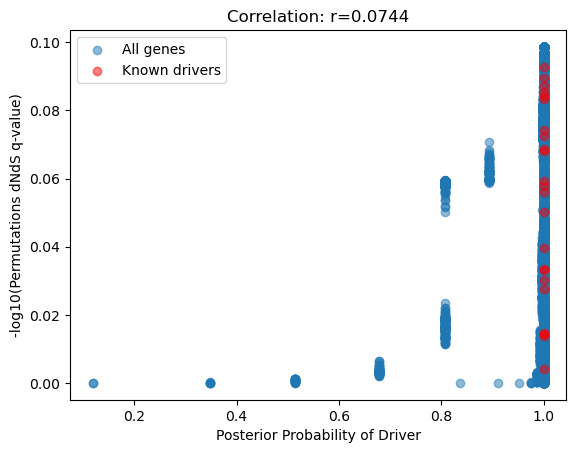

In [223]:
# Posterior vs. q-value
import matplotlib.pyplot as plt
plt.scatter(perm_mut['posterior_driver'], -np.log10(perm_mut['p_adj']), alpha=0.5)

# Label known cancer drivers
# known_drivers_df = pd.read_csv('/Users/aleyshachen/BENG_285/proj_2/IntOGen-DriverGenes_LUAD.csv')
# known_drivers = known_drivers_df['Symbol'].tolist()
# known_drivers = [x.lower() for x in known_drivers]
X = perm_mut[perm_mut['Hugo_Symbol'].notna() & perm_mut['Hugo_Symbol'].isin(known_drivers)]['posterior_driver'].fillna(0).to_numpy().reshape(-1, 1)
y = -np.log10(perm_mut[perm_mut['Hugo_Symbol'].notna() & perm_mut['Hugo_Symbol'].isin(known_drivers)]['p_adj'])

# Filter out rows where y contains infinite values
finite_mask = np.isfinite(y)
X = X[finite_mask]
y = y[finite_mask]

# Add correlation line
# from scipy.stats import linregress
# Fit with intercept = 0
model = LinearRegression(fit_intercept=False)
model.fit(X, y)

# Predict line
y_pred = model.predict(X)
ss_res = np.sum((y - y_pred) ** 2)
ss_tot = np.sum(y ** 2)
r_squared = 1 - (ss_res / ss_tot)
plt.title(f"Correlation: r={r_squared:.4f}")
plt.scatter(perm_mut[perm_mut['Hugo_Symbol'].isin(known_drivers)]['posterior_driver'], -np.log10(perm_mut[perm_mut['Hugo_Symbol'].isin(known_drivers)]['p_adj']), color='red', alpha=0.5)
# plt.plot(perm_mut[perm_mut['Hugo_Symbol'].isin(known_drivers)]['posterior_driver'], y_pred, color='black', linestyle='dashed')
plt.xlabel('Posterior Probability of Driver')
plt.ylabel('-log10(Permutations dNdS q-value)')
plt.legend(['All genes', 'Known drivers'])

# Comparison with IntOGene cancer-driver genes

In [ ]:
# Compute Jaccard index for likely driver genes vs. IntOGene set
def jaccard_index(set_a, set_b):
    intersection = len(set_a.intersection(set_b))
    union = len(set_a.union(set_b))
    return intersection / union if union > 0 else 0
# Example sets (replace with your real data)
dndscv_sig = pd.read_csv('data/evaluation/dndscv_significant_drivers.csv')
sig_genes = set(dndscv_sig['gene_name'].to_list())
# intogene_set = set(['gene2', 'gene3', 'gene4', 'gene5'])
# Compute Jaccard index
jaccard = jaccard_index(sig_genes, known_drivers)
print(f"Jaccard index: {jaccard:.3f}")

Jaccard index: 0.007


In [83]:
custom_sig_genes = set(custom_mut[custom_mut['significant']]['gene_name'].to_list())
custom_jaccard = jaccard_index(custom_sig_genes, known_drivers)
print(f"Custom Jaccard index: {custom_jaccard:.3f}")


Custom Jaccard index: 0.052


In [151]:
perm_sig_genes = set(['ATM', 'ARID1A', 'BRAF', 'C8B', 'CELF4', 'COL12A1', 'COL11A1', 'DMXL1', 'DST', 'FLG', 'KEAP1', 'LPPR4', 'MROH2B', 'NF1', 'NOTCH4', 'SETD2', 'SMARCA4', 'STK11', 'TP53', 'TRIM48', 'ZBBX', 'ZNF98'])
perm_jaccard = jaccard_index(perm_sig_genes, known_drivers)
print(f"Perm Jaccard index: {perm_jaccard:.3f}")

Perm Jaccard index: 0.100


In [ ]:
am_sig = pd.read_csv('data/benchmark/gene_results_with_am_significance.csv')
am_sig_genes = set(am_sig[am_sig['am_significant']]['gene_name'].to_list())
am_jaccard = jaccard_index(am_sig_genes, known_drivers)
print(f"AM Jaccard index: {am_jaccard:.3f}")

AM Jaccard index: 0.040


<Axes: >

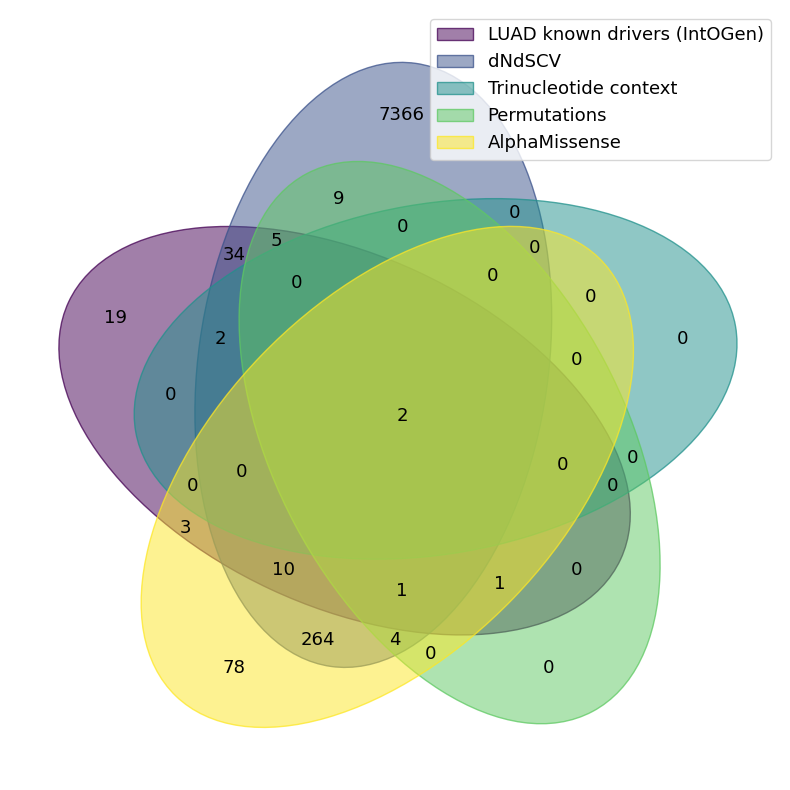

In [209]:
from venn import venn
# Create a Venn diagram
venn({
    'LUAD known drivers (IntOGen)': set(known_drivers),
    'dNdSCV': set(sig_genes),
    'Trinucleotide context': set(custom_sig_genes),
    'Permutations': set(perm_sig_genes),
    'AlphaMissense': set(am_sig_genes)
}, figsize=(10, 10), fontsize=13, alpha=0.5
)
